# Notebook baseline scenario

Basis = notebook Hannah

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display
plt.rcParams['font.size'] = '14'

skip_edgegif = True

## Hypothetisch terrein

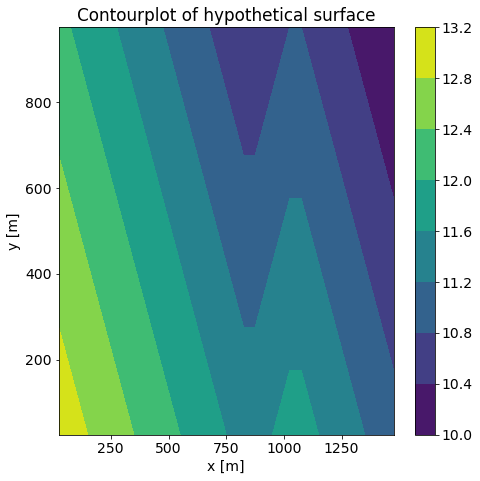

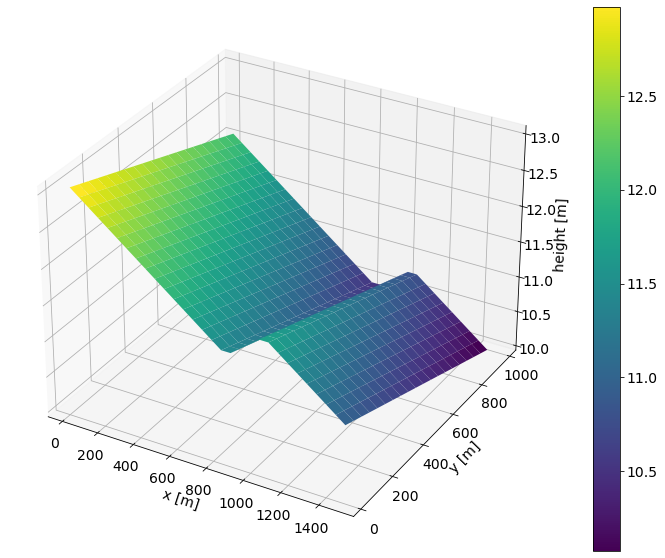

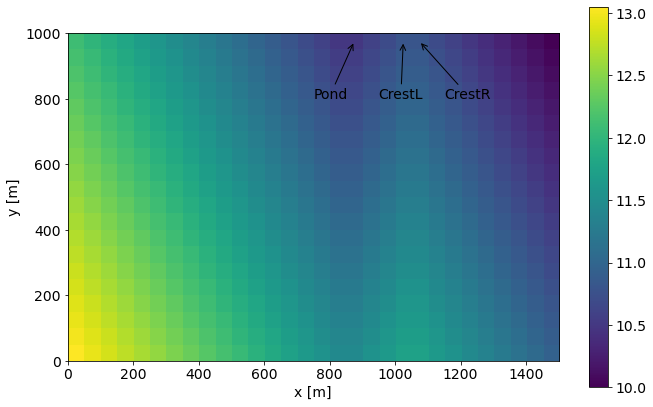

In [6]:
runfile('Grid_hypoth.py')
#convectie: grid[y,x] om zo met contour functies te kunnen werken!

Text(0, 0.5, 'y [m]')

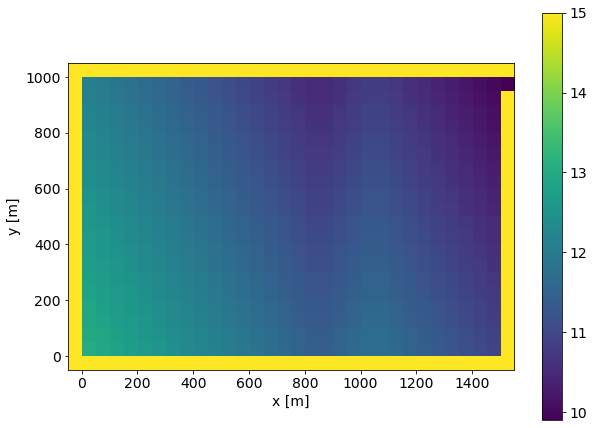

In [7]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions
grid_imag[:,0] = 15
grid_imag[:-1,-1] = 15
grid_imag[-2,-1] = grid[-1,-1] - (slopex*deltax) #dus wegdraineren met zelfde gradient
grid_imag[0,:] = 15
grid_imag[-1,:] = 15
plt.figure(figsize = (10,7.5))
plt.imshow(np.flipud(grid_imag), extent = [np.min(xs)-3*deltax/2, np.max(xs)+3*deltax/2,
np.min(ys)-3*deltay/2,np.max(ys)+3*deltay/2])
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')

## Outflux functies en time loop voor variabele $\Delta$t

Aangepaste OutfluxNH functie voor de eerste loop; heeft geen $\Delta$t als input en berekent geen v*. Lichte aanpassing: maak de manning coefficient een input waarde. 

Aangepaste OutfluxNH functie voor alle overige loops; heeft $\Delta$t uit de vorige loop als input en berekent op basis van de met v gecorrigeerde v* een nieuwe $\Delta$t.

In [8]:
runfile('Outfluxfuncties.py')

Time loop:

In [9]:
# Parameters definiëren
Acell = deltax*deltay
tend = 500*60
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd). Wanneer dit op 1 heeft dit effectief enkel effect op de m
n = 0.01 #manning coefficiënt

# Initialisatie
deltat = 10*60
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax, n)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.max(vmax_list[:])
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
#depths_imag_new[-2,-1] = 0 #uitstroomcel legen
# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
if t > duration and t_list[-2] < duration: #dit is dus scenario waarbij NET de één uur overschrijden
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration - t_list[-2])
        print('nieuwe stap werkt')
depths_list.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax, n)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    #if not(np.isnan(np.max(vjmax_list))): #CORRIGEER VOOR DE NAN DIE OPTREED
    deltat = deltax/np.nanmax(vjmax_list) #aanpassing Hannah
    #print(deltat)
    t = t + deltat
    t_list.append(t)
    if t % 1000 < 10:
        print(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    #depths_imag_new[-2,-1] = 0 #uitstroomcel legen. Even niet doen voor vergl
    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    if t > duration and t_list[-2] < duration: #dit is dus scenario waarbij NET de één uur overschrijden
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration - t_list[-2])
        print('nieuwe stap werkt')
    depths_list.append(depths_imag_new)

492.8888079942049
nieuwe stap werkt


Outfluxfuncties.py:172: RuntimeWarning: invalid value encountered in double_scalars
  v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
Outfluxfuncties.py:173: RuntimeWarning: invalid value encountered in sqrt
  v_critical = np.sqrt(g*d)


11008.809455274913


In [10]:
runfile('gif_functie.py')

In [11]:
if skip_edgegif == False:
    gif_maken_bis(depths_list, t_list, 4, 'gif_variabeleDeltat_nancorr_nooutflux')

Proberen plotten zonder de randen

...............................................................................................Gif opgeslaan als gif_variabeleDeltat_nancorr_nooutflux_noedge


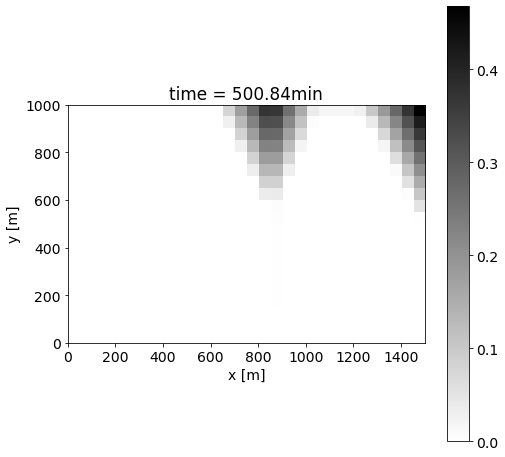

In [12]:
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)

gif_maken_bis(depths_list_bis, t_list, 4, 'gif_variabeleDeltat_nancorr_nooutflux_noedge')

## Figuur 4 nabootsen

Plot de figuren om de benchmark in de paper zo goed mogelijk na te bootsen. 

In [13]:
times_interest = [40*60,60*60,100*60,200*60]
locs = []
for i in range(len(times_interest)):
    locations = np.where(np.array(t_list) > times_interest[i])
    locs.append(locations[0][0])
locs

[10, 23, 59, 143]

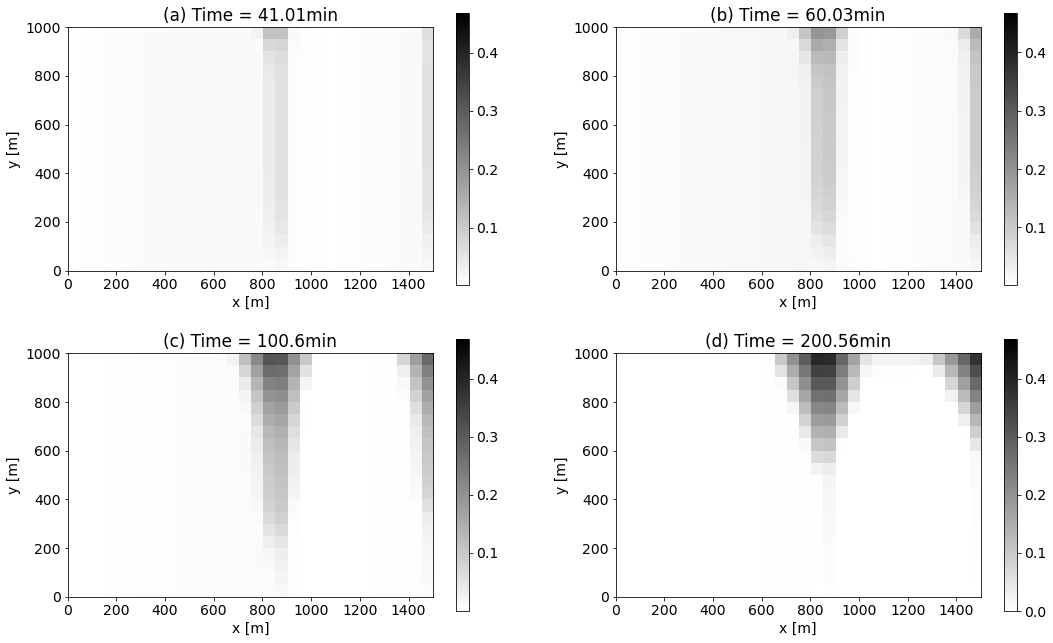

In [15]:
max_depth = np.max(depths_list_bis[:])
letters = ['(a)','(b)','(c)','(d)']
plt.figure(figsize = (18,11))
for i in range(len(locs)):
    plt.subplot(2,2,i+1)
    hoogtes = depths_list_bis[locs[i]]
    plt.imshow(np.flipud(hoogtes), vmax = max_depth, cmap = 'binary', extent = [0,1500,0,1000])
    plt.colorbar()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title(letters[i] + ' Time = '+ str(np.round(t_list[locs[i]]/60,2)) + 'min')
plt.savefig('Afbeeldingen/Figuur4_artikel.png',dpi =300)
plt.savefig('AfbeeldingenPDF/Figuur4_artikel.pdf')

## Figuur 5 nabootsen

In [16]:
depths_list_bis = [] 
for i in range(len(depths_list)):
    bisframe = depths_list[i][1:-1,1:-1]
    depths_list_bis.append(bisframe)


Text(0.5, 1.0, 'Pond')

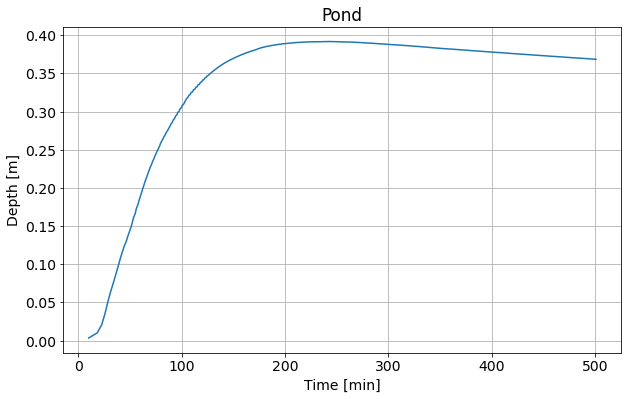

In [17]:
depth_pond_list = []
t_list_min = []
for i in range(len(t_list)):
    depth_pond = depths_list_bis[i][-1,17]
    depth_pond_list.append(depth_pond)
    t_list_min.append(t_list[i]/60)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min, depth_pond_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('Pond')

Text(0.5, 1.0, 'CrestL')

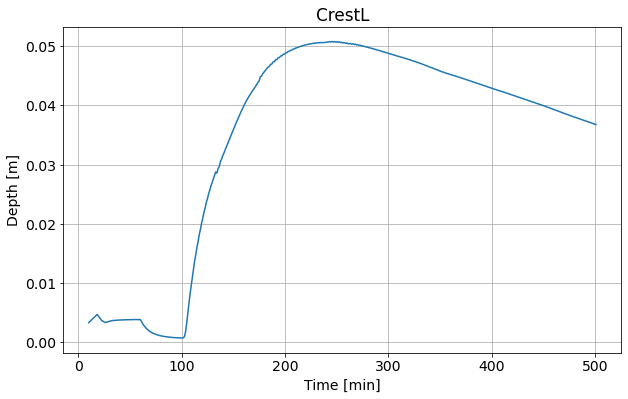

In [18]:
depth_crestL_list = []
t_list_min = []
for i in range(len(t_list)):
    depth_crestL = depths_list_bis[i][-1,20]
    depth_crestL_list.append(depth_crestL)
    t_list_min.append(t_list[i]/60)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min, depth_crestL_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('CrestL')

Text(0.5, 1.0, 'CrestR')

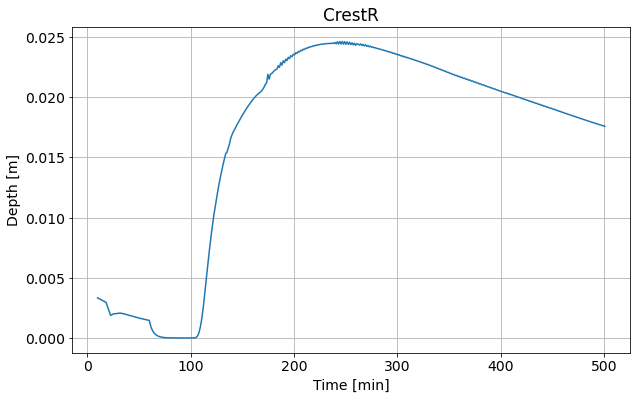

In [19]:
depth_crestR_list = []
t_list_min = []
for i in range(len(t_list)):
    depth_crestR = depths_list_bis[i][-1,21]
    depth_crestR_list.append(depth_crestR)
    t_list_min.append(t_list[i]/60)

plt.figure(figsize = (10,6))
plt.grid(b=True)
plt.plot(t_list_min, depth_crestR_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('CrestR')

Resultaten komen zeker in de buurt, maar ons model lijkt trager te verlopen. Indiceert dat tijdstapidee een struikeblok blijft voor de correcte implementatie. 

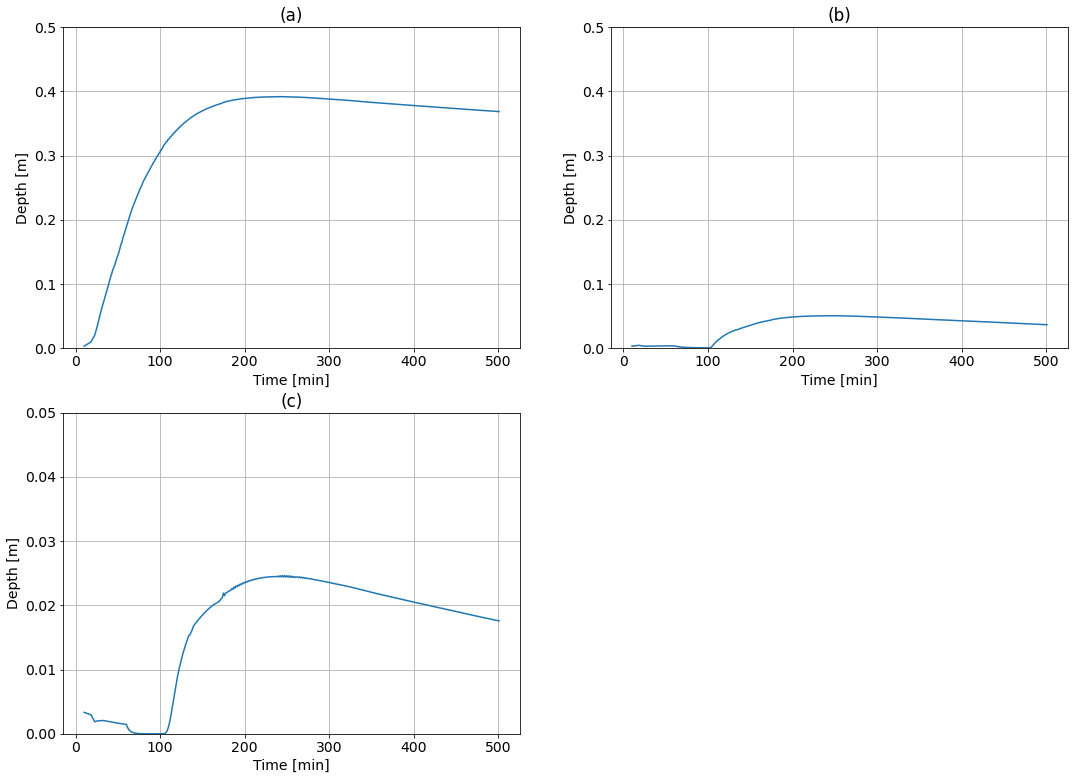

In [28]:
plt.figure(figsize = (18,13))
plt.subplot(2,2,1)
plt.grid(b=True)
plt.plot(t_list_min, depth_pond_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('(a)')
plt.ylim((0,0.5))

plt.subplot(2,2,2)
plt.grid(b=True)
plt.plot(t_list_min, depth_crestL_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.ylim((0,0.5))
plt.title('(b)')

plt.subplot(2,2,3)
plt.grid(b=True)
plt.plot(t_list_min, depth_crestR_list)
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
plt.title('(c)')
plt.ylim((0,0.05))

plt.savefig('Afbeeldingen/depth_hydrographs.png', dpi = 300)
plt.savefig('AfbeeldingenPDF/depth_hydrographs.pdf')

# Scenario met bomen i.p.v. smooth asfalt

Volgens [Chow](http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm) komt een n van 0.013 overeen met egale asfalt. Deze waarde dicht bij de 0.01 van de opgave. Voor een floodplain bestaande uit wilgen echter, ligt deze n veel hoger op 0.150! Hiervan effect dus eens nagaan. Voor de rest zelfde scenario als eerder (niet legen van de cellen, zelfde grid etc. )

In [21]:
init_tijden = [10,20]
depths_list_trees_list = []
t_list_trees_list = []
for i in init_tijden:
    # Parameters definiëren
    Acell = deltax*deltay
    tend = 500*60 #zo vergelijking met vorige hydrogram
    rain = 20/(1000*3600) #regenval in m/s
    duration = 3600 
    theta = 0.7 #relaxatieparameter (gekalibreerd). Wanneer dit op 1 heeft dit effectief enkel effect op de m
    n = 0.150 #GEWIJZIGD

    # Initialisatie
    deltat = i*60 #moeilijk hier: 10 of 20 minuten aan initiele regen? 
    depths_imag = np.zeros((ny+2,nx+2))
    depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h
    t_list_trees = [] #lijst met tijdstappen
    t = deltat
    t_list_trees.append(t)
    depths_list_trees = [] #lijst met waterdieptes voor alle tijdstap
    depths_list_trees.append(depths_imag)


    ##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list_trees[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax, n)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vmax_list.append(vmax_NH)
        
    # Globale tijdstap updaten
    deltat = deltax/np.max(vmax_list[:])
    print(deltat)
    t = t + deltat
    t_list_trees.append(t)
        
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    #depths_imag_new[-2,-1] = 0 #uitstroomcel legen
    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    if t_list_trees[-2] < duration and t > duration: #dit is dus scenario waarbij NET de één uur overschrijden
            print('nieuwe stap werkt')
            depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration - t_list_trees[-2])
    depths_list_trees.append(depths_imag_new)


    ##2## Overige iteraties in de tijd => functie OutfluxNH2
    while t < tend:
        fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
        depths_imag = depths_list_trees[-1]
        depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
        vjmax_list = []
        for j in np.arange(1,ny+1):
            for i in np.arange(1,nx+1):
                # Hoogtes in neighbourhood
                hneigb1 = grid_imag[j,i+1]
                hneigb2 = grid_imag[j+1,i]
                hneigb3 = grid_imag[j,i]
                hneigb4 = grid_imag[j-1,i]
                hneigb5 = grid_imag[j,i-1]
                NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
                # Waterdieptes in neighbourhood
                dneigb1 = depths_imag[j,i+1]
                dneigb2 = depths_imag[j+1,i]
                dneigb3 = depths_imag[j,i]
                dneigb4 = depths_imag[j-1,i]
                dneigb5 = depths_imag[j,i-1]
                NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
                # Outflow fluxes berekenen
                F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax, n)
                F1 = F[0]
                F2 = F[1]
                F4 = F[2]
                F5 = F[3]
                # Toekennen van totale outflow flux centrale cel (!)
                F3 = -F1-F2-F4-F5 
                fluxes_imag[2,j,i] = F3
                # Toekennen van inflow fluxes naburige cellen
                fluxes_imag[3,j,i+1] = F1
                fluxes_imag[4,j+1,i] = F2
                fluxes_imag[0,j-1,i] = F4
                fluxes_imag[1,j,i-1] = F5
                # vmax_NH opslaan in lijst
                vjmax_list.append(vjmax_NH)
        
        # Globale tijdstap updaten.
        #if not(np.isnan(np.max(vjmax_list))): #CORRIGEER VOOR DE NAN DIE OPTREED
        deltat = deltax/np.nanmax(vjmax_list) #aanpassing Hannah
        #print(deltat)
        t = t + deltat
        t_list_trees.append(t)
        #if t % 1000 < 10:
        #    print(t)
        print(deltat)
        
                
        depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
        #depths_imag_new[-2,-1] = 0 #uitstroomcel legen. Even niet doen voor vergl
        # Regenval toevoegen aan waterdiepte
        if t < duration: #alleen in het eerste uur
            depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
            print('oude constructie werkt')
        if t_list_trees[-2] < duration: #dit is dus scenario waarbij NET de één uur overschrijden
            print('nieuwe stap werkt')
            depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration - t_list_trees[-2])
        depths_list_trees.append(depths_imag_new)
    depths_list_trees_list.append(depths_list_trees)
    t_list_trees_list.append(t_list_trees)

7393.332119913074
nieuwe stap werkt
1930.4265288041734
1405.1673861492632
1482.8104479395986
1487.2789086315624
1395.3869138235234
1324.2813707993018
1264.8080703695096
1211.9066499736682
1167.494470297248
1135.4833442134332
1110.3523936775587
1094.441994742054
1081.4693976213691
1070.5997980186935
1061.615532387243
1020.4860832543883
1047.525335564531
1013.3789978311236
4584.156226241633
nieuwe stap werkt
1806.6831710422691
1357.451533196668
1532.9129903856797
1453.2005815790656
1370.0226305013177
1321.1139757415463
1255.49789517379
1205.8751099113147
1162.3536464544188
1132.8716447461616
1108.4383822548364
1093.0239399773086
1080.3992844970269
1069.821675444245
1060.9479412206258
1014.1880288871507
1047.1757305133501
1006.3548456919367
1032.0463487209963
994.9694487683313
1019.1934539463884


In [22]:
t_list_trees[-2]

29889.505030949676

...........Gif opgeslaan als naam_gif
.............Gif opgeslaan als naam_gif


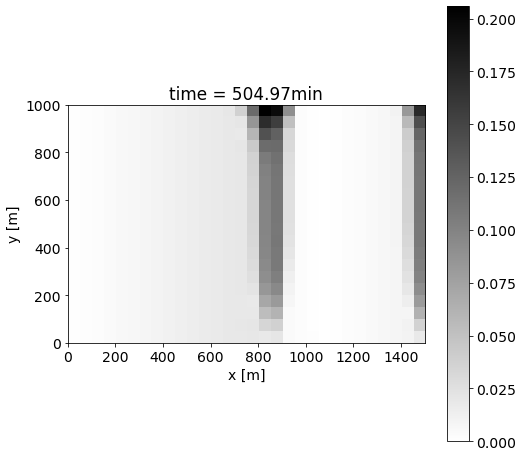

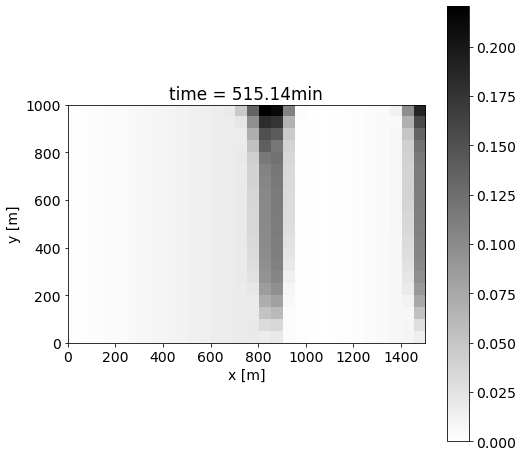

In [23]:
depths_list_trees_bis_list = []
index = 0
for k in init_tijden:
    depths_list_trees_bis = [] 
    depths_list_trees = depths_list_trees_list[index]
    t_list_trees = t_list_trees_list[index]
    for i in range(len(depths_list_trees)):
        bisframe = depths_list_trees[i][1:-1,1:-1]
        depths_list_trees_bis.append(bisframe)

    len(depths_list_trees)
    naam_gif = 'wilgen_overstroming_' + str(k) +'init'
    gif_maken_bis(depths_list_trees_bis, t_list_trees, 2, 'naam_gif')
    index = index + 1
    depths_list_trees_bis_list.append(depths_list_trees_bis)

Bemerk dat deze langere tijd in de realiteit een zeer groot verschil zou maken omdat er dan ook infiltratie optreed! Dit is dus een belangrijk element dat wordt genegeerd in het huidig model, maar dat in een niet-stedelijke gebetonneerde gebieden van groot belang is! Bemerk: 60*24 min in een dag = 1440 min. Dus neem bijvoorbeeld 2 dagen => in die tijd kan er al zeer veel infiltreren! 

PROBLEEM: de sterke afhankelijkheid van de initiële tijdstap! Wordt hier verder geëxploreerd. 

In [24]:
times_interest = [200*60]
locs = []
for i in range(len(depths_list_trees_bis_list)):
    t_list = t_list_trees_list[i]
    locations = np.where(np.array(t_list) > times_interest)
    locs.append(locations[0][0])
locs

[4, 6]

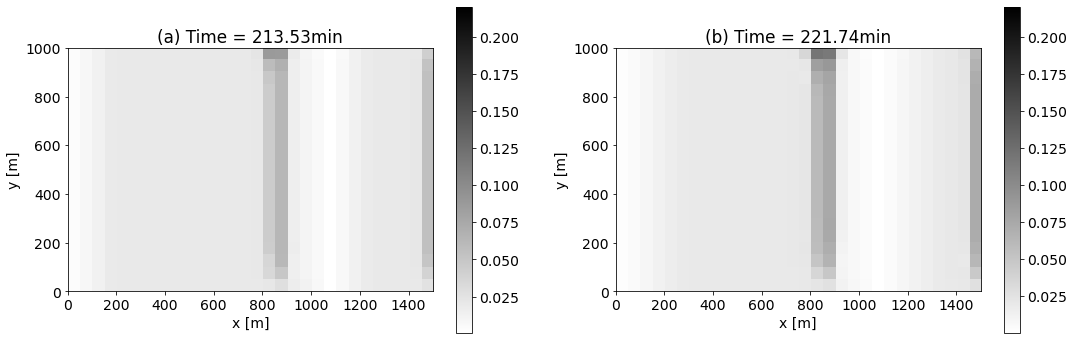

In [25]:
max_depth =np.max([np.max(depths_list_trees_bis_list[0]),np.max(depths_list_trees_bis_list[1])])
letters = ['(a)','(b)','(c)','(d)']
plt.figure(figsize = (18,6))
index = 0
for i in range(len(locs)):
    plt.subplot(1,2,i+1)
    hoogtes = depths_list_trees_bis_list[index][locs[i]]
    plt.imshow(np.flipud(hoogtes), vmax = max_depth, cmap = 'binary', extent = [0,1500,0,1000])
    plt.colorbar()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    t_list = t_list_trees_list[index]
    plt.title(letters[i] + ' Time = '+ str(np.round(t_list[locs[i]]/60,2)) + 'min')
    index = index + 1
plt.savefig('Afbeeldingen/Willow_200min.png',dpi =300)
plt.savefig('AfbeeldingenPDF/Willow_200min.pdf')

In [26]:
np.max([np.max(depths_list_trees_bis_list[0]),np.max(depths_list_trees_bis_list[0])])

0.20577503908691305

Illustreert dus dat huidige model NIET bruikbaar is voor gebieden waar wel infiltratie optreden kan! Blijft enkel een urbaan overstromingsmodel. 

Maak hydrogram en vergelijk met het vorige scenario. 

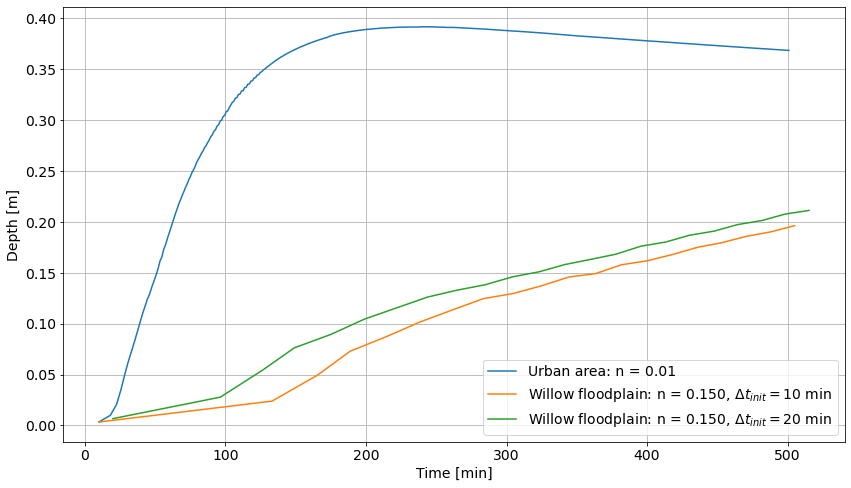

In [27]:
t_list_trees_min_list = []
depth_pond_list_trees_list = []
index = 0
for k in init_tijden:
    depth_pond_list_trees = []
    t_list_trees_min = []
    t_list_trees = t_list_trees_list[index]
    depths_list_trees_bis = depths_list_trees_bis_list[index]
    for i in range(len(t_list_trees)):
        depth_pond = depths_list_trees_bis[i][-1,17]
        depth_pond_list_trees.append(depth_pond)
        t_list_trees_min.append(t_list_trees[i]/60)
    t_list_trees_min_list.append(t_list_trees_min)
    depth_pond_list_trees_list.append(depth_pond_list_trees)
    index = index + 1

plt.figure(figsize = (14,8))
plt.grid(b=True)
plt.plot(t_list_min, depth_pond_list, label ='Urban area: n = 0.01')
plt.plot(t_list_trees_min_list[0], depth_pond_list_trees_list[0], label = r'Willow floodplain: n = 0.150, $\Delta t_{init} = 10$ min')
plt.plot(t_list_trees_min_list[1], depth_pond_list_trees_list[1], label = r'Willow floodplain: n = 0.150, $\Delta t_{init} = 20$ min')
plt.xlabel('Time [min]')
plt.ylabel('Depth [m]')
#plt.title('Pond')
plt.legend()
plt.savefig('Afbeeldingen/Willow_hydrogaph.png', dpi = 300)
plt.savefig('AfbeeldingenPDF/Willow_hydrogaph.pdf')

Bemerk dus een veel trager hydrogram!! In realiteit niet zo nuttig om dus veel verder te gaan deze 500 min (ongeveer 8,5u omdat we infiltratie en evapotranspiratie dus aan het verwaarlozen zijn)